In [1]:
#!unzip dank_data-master.zip
#!pip install tensorflow_addons

In [2]:
import glob
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten,Embedding,LSTM,concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa
import logging
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
training='/content/dank_data-master/data/training/*'
test='/content/dank_data-master/data/test/*'
validation='/content/dank_data-master/data/validation/*'

In [4]:
training = glob.glob(training)
test = glob.glob(test)
validation = glob.glob(validation)

In [5]:
final_dank=pd.read_csv('/content/dank_data-master/data/final_dank.csv')
train_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in training]
validation_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in validation]
test_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in test]

In [6]:
for labels in train_labels:
    if labels==train_labels[0]:
        train_data =final_dank[final_dank['id']==labels]
    else :
        train_data =train_data.append(final_dank[final_dank['id']==labels],sort=False)
for labels in validation_labels:
    if labels==validation_labels[0]:
        val_data =final_dank[final_dank['id']==labels]
    else :
        val_data =val_data.append(final_dank[final_dank['id']==labels],sort=False)
for labels in test_labels:
    if labels==test_labels[0]:
        test_data =final_dank[final_dank['id']==labels]
    else :
        test_data =test_data.append(final_dank[final_dank['id']==labels],sort=False)
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)
train_data.head(5)

(3405, 68)
(1719, 68)
(1688, 68)


,Unnamed: 0,level_0,index,author,awards,processed_words,created_utc,downs,id,is_nsfw,media,subreddit,subscribers,thumbnail.height,thumbnail.thumbnail,thumbnail.width,title,ups,url,datetime_temp,time_of_day,ups_normed,dank_level,TextLength,Sentiment,word_count,avg_blueRGB,avg_greenRGB,avg_hue,avg_redRGB,avg_saturation,avg_value,off-white,aqua,mustard,pure-black,purple,red-brown,dust-brown,gray-blue,orange,salmon,dark-green,pink,pure-white,yellow-green,bright-yellow,teal,cyan,gray,maroon,olive,light-blue,plum,siena-brown,gold,pure-red,pure-green,pure-blue,coral,peach,col,vgg1_prob,vgg2_prob,vgg3_prob,vgg_feature_1,vgg_feature_2,vgg_feature_3
27060,48660,50940.0,50940.0,FreezeY7,[],"['gamer', 'xbox', 'xbox', 'playstat']",1.584235e+09,0.0,fit80n,False,https://i.redd.it/5cpizrgflqm41.jpg,r/memes,9552902.0,136.0,default,140.0,Gamers unite,4430.0,/r/memes/comments/fit80n/gamers_unite/,2020-03-14 20:10:36,4.0,4.637334e-04,1.0,61.0,0.49,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29398,52076,54537.0,54537.0,sraff57,[],"['wait', 'metowißi', 'stick', 'know', 'rule', ...",1.584217e+09,0.0,fios8u,False,https://i.redd.it/t23cfasb5pm41.jpg,r/memes,9552912.0,140.0,https://a.thumbs.redditmedia.com/I-6emwPP50CaM...,140.0,"Wait, what are you doing?!?!",2085.0,/r/memes/comments/fios8u/wait_what_are_you_doing/,2020-03-14 15:18:34,3.0,2.182581e-04,1.0,100.0,0.43,6.0,117.131659,135.557786,9.252348,161.599832,112.027603,161.619876,1.452131,0.0,0.0,1.479624,0.0,3.574983,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.306579,3.693118,0.0,0.0,0.0,0.0,59.748012,0.0,0.0,0.0,0.0,0.000000,0.014749,0.565066,0.060382,0.035474,web_site,book_jacket,bulletproof_vest
53584,96576,1088.0,32741.0,sdrisc2692,[],"['reddit', 'mobil', 'reddit', 'mobil', 'mind']",1.584914e+09,0.0,fn80tk,False,https://i.redd.it/647g7iqfpao41.jpg,r/memes,10674286.0,140.0,https://b.thumbs.redditmedia.com/Zh-ilteB7oXYR...,140.0,To sum up reddit mobile:,20.0,/r/memes/comments/fn80tk/to_sum_up_reddit_mobile/,2020-03-22 16:52:49,3.0,1.873662e-06,0.0,49.0,0.45,5.0,114.411775,150.795775,15.035978,161.424079,116.582826,162.304915,2.387553,0.0,0.0,6.700281,0.0,0.001293,1.151742,0.000000,0.065962,0.230866,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.142689,0.000000,0.0,0.0,0.0,0.0,27.123174,0.0,0.0,0.0,0.0,0.230866,0.015520,0.680993,0.067452,0.050404,web_site,Granny_Smith,banana
27044,48639,50917.0,50917.0,meeeeeeeph,[],"['meme', 'youtub', 'break', 'real', 'genuin', ...",1.584235e+09,0.0,fit9g6,False,https://i.redd.it/dcz9h7bylqm41.jpg,r/memes,9552902.0,140.0,default,140.0,This isn’t a meme but this youtuber just broke...,1.0,/r/memes/comments/fit9g6/this_isnt_a_meme_but_...,2020-03-14 20:13:34,4.0,1.046802e-07,0.0,451.0,0.70,26.0,157.262803,150.143991,81.755107,154.083191,43.572516,167.579094,8.594830,0.0,0.0,1.996332,0.0,0.000555,0.143401,0.372659,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.006846,0.0,1.995962,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.123341,0.312252,0.043995,0.039401,comic_book,refrigerator,can_opener
14024,29120,30519.0,30519.0,pronoob-_-,[],"['corona', 'ᕗfinal', 'report', 'test', 'dengu'...",1.584364e+09,0.0,fjkmt5,False,https://i.redd.it/xqrdd00s91n41.jpg,r/memes,9552837.0,140.0,https://b.thumbs.redditmedia.com/18UmvLAPuBZWb...,140.0,No Corona for me ᕙ( ͡◉ ͜ ʖ ͡◉)ᕗ,5753.0,/r/memes/comments/fjkmt5/no_corona_for_me_ᕙ_ʖ_ᕗ/,2020-03-16 08:04:56,1.0,6.022295e-04,1.0,290.0,0.44,21.0,87.709108,92.152124,68.006554,97.757133,62.503956,103.276077,2.418405,0.0,0.0,1.275989,0.0,0.008372,1.187321,0.125201,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,3.162003,0.001142,0.0,0.0,0.0,0.0,0.144990,0.0,0.0,0.0,0.0,0.000000,0.641229,0.545186,0.064092,0.055442,lumbermill,thresher,horse_cart


In [7]:
def file_extension(x):
      return x+".jpg"
train_data['id'] = train_data['id'].apply(file_extension)
val_data['id'] = val_data['id'].apply(file_extension)
test_data['id'] = test_data['id'].apply(file_extension)

In [8]:
def numeric_to_string(x):
    if (x==1.0):
        return 'Not_dank'
    elif (x==0.0):
        return 'Dank'
train_data['dank_level_new'] = train_data['dank_level'].apply(numeric_to_string)
val_data['dank_level_new'] = val_data['dank_level'].apply(numeric_to_string)
test_data['dank_level_new'] = test_data['dank_level'].apply(numeric_to_string)

In [9]:
  logger = logging.getLogger()
  logger.disabled = False  
  train_datagen = ImageDataGenerator(zoom_range=0.3, rotation_range=50,
                                    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                    horizontal_flip=True, fill_mode='nearest')
  train_generator = train_datagen.flow_from_dataframe(
              dataframe=train_data,
              directory="/content/dank_data-master/data/training/",
              x_col="id",
              y_col="dank_level_new",
              subset="training",
              batch_size=30,
              seed=42,
              class_mode="binary",
              target_size= (156,156))
  predict_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
  train_prediction_generator = predict_datagen.flow_from_dataframe(
              dataframe=train_data,
              directory="/content/dank_data-master/data/training/",
              x_col="id",
              y_col="dank_level_new",
              batch_size=30,
              seed=42,
              class_mode="binary",
              shuffle=False,
              target_size= (156,156))
  validation_prediction_generator = predict_datagen.flow_from_dataframe(
              dataframe=val_data,
              directory="/content/dank_data-master/data/validation/",
              x_col="id",
              y_col="dank_level_new",
              batch_size=30,
              seed=42,
              shuffle=False,
              class_mode="binary",
              target_size= (156,156))
  test_prediction_generator = predict_datagen.flow_from_dataframe(
              dataframe=test_data,
              directory="/content/dank_data-master/data/test/",
              x_col="id",
              y_col="dank_level_new",
              batch_size=30,
              seed=42,
              shuffle=False,
              class_mode="binary",
              target_size= (156,156))

Found 3405 validated image filenames belonging to 2 classes.
Found 3405 validated image filenames belonging to 2 classes.
Found 1688 validated image filenames belonging to 2 classes.
Found 1719 validated image filenames belonging to 2 classes.


In [10]:
IMAGE_SIZE = [156,156]
ResNet50 = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


In [11]:
for layer in ResNet50.layers:
    layer.trainable = False

In [12]:
#Flatten
flatten = Flatten(data_format='channels_last',name='Flatten')(ResNet50.output)

#FC layer
FC1 = Dense(units=512,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC1')(flatten)
x = Dropout(0.3)(FC1)
#FC layer
FC2 = Dense(units=256,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33),name='FC2')(x)
x = Dropout(0.3)(FC2)
#FC layer
FC3 = Dense(units=128,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33),name='FC3')(x)
x = Dropout(0.3)(FC3)
#FC layer
FC4 = Dense(units=64,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33),name='FC4')(x)
x = Dropout(0.3)(FC4)

#output layer
Out = Dense(units=1,activation='sigmoid',kernel_initializer=tf.keras.initializers.glorot_normal(seed=3),name='Output')(x)

model = Model(inputs=ResNet50.input, outputs=Out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 156, 156, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 162, 162, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 78, 78, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 78, 78, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
def scheduler(epoch,lr):
    if((epoch+1)%3==0):
        lr=lr*0.95
        return lr
    else:
        return lr

In [14]:

filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',mode='auto')



lrschedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=0.1)

#stop the training if your validation accuracy is not increased in last 2 epochs.
early_stop= EarlyStopping(monitor='val_accuracy', patience=3,verbose=1) 

#If your validation accuracy at that epoch is less than previous epoch accuracy, you have to decrese the
#learning rate by 10%
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                              patience=3, min_lr=0.001,verbose=1)

model.compile(
  loss='binary_crossentropy',
  optimizer=tf.keras.optimizers.RMSprop(lr=1e-5), 
  metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tfa.metrics.F1Score(num_classes=1)]
)


In [15]:
history=model.fit_generator(train_generator,steps_per_epoch=len(train_generator),epochs=50,validation_data=test_prediction_generator,validation_steps=len(test_prediction_generator),use_multiprocessing=False,workers=12,callbacks=[lrschedule,checkpoint,reduce_lr])

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
114/114 [==============================] - 131s 803ms/step - loss: 1.0947 - accuracy: 0.5207 - precision: 0.5131 - recall: 0.5313 - f1_score: 0.6602 - val_loss: 0.7159 - val_accuracy: 0.5183 - val_precision: 0.5024 - val_recall: 0.3791 - val_f1_score: 0.6518
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
114/114 [==============================] - 94s 777ms/step - loss: 0.8673 - accuracy: 0.5102 - precision: 0.5097 - recall: 0.4941 - f1_score: 0.6658 - val_loss: 0.7060 - val_accuracy: 0.5137 - val_precision: 0.4965 - val_recall: 0.4308 - val_f1_score: 0.6518
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 9.499999760009813e-06.
114/114 [==============================] - 97s 796ms/step - loss: 0.7841 - accuracy: 0.5270 - precision: 0.5277 - recall: 0.5327 - f1_score: 0.6674 - val_loss: 0.7028 - val_accuracy: 0.5032 - val

In [17]:
model_checkpoint =  Model(inputs=ResNet50.input, outputs=Out)
model_checkpoint.load_weights('/content/model_save/weights-04-0.5079.h5')
model_checkpoint.save('bestmodel_resnet50.h5')
new_model = tf.keras.models.load_model('bestmodel_resnet50.h5')

In [18]:
test_prediction=new_model.predict_generator(test_prediction_generator,steps=len(test_prediction_generator),workers=12)
test_prediction=((test_prediction > 0.5)+0).ravel() 
print(test_prediction.shape)
y_test =tf.keras.utils.to_categorical(test_data['dank_level'].values,2)
y_test=np.argmax(y_test,axis=-1)
y_test.shape

(1719,)


(1719,)

Test accuracy_score 0.5078534031413613
Test F1_score 0.4994082840236686
Test confusion matrix


Text(0.5, 15.0, 'Predicted label')

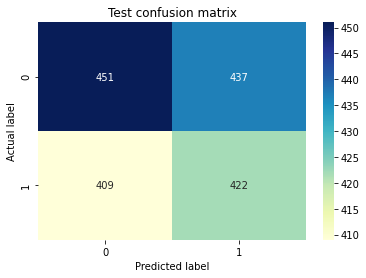

In [19]:
accuracy=accuracy_score(y_test,test_prediction)
print("Test accuracy_score",accuracy)
f1_test_score=f1_score(y_test,test_prediction)
print("Test F1_score",f1_test_score)
print("Test confusion matrix")
cnf_matrix2=confusion_matrix(y_test,test_prediction)
p = sns.heatmap(pd.DataFrame(cnf_matrix2), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Test confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

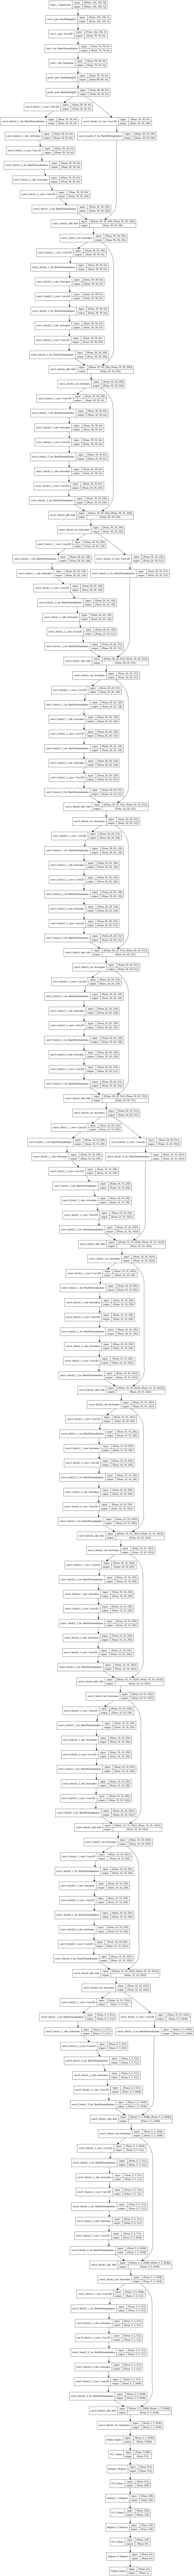

In [20]:
file = '/content/model_1.png'
tf.keras.utils.plot_model(model,to_file=file, show_shapes=True)